# Week 40 - mBERT Classifying Span containing Answer

In [1]:
import gc
import os
import polars as pl
import torch

# Huggingface imports
from transformers import (
    AutoTokenizer,
    BertForTokenClassification,
    Seq2SeqTrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

# Import own modules
from bert_utils import (
    bio_sequence_labeler,
    get_results,
    display_results,
)

from datasets import load_dataset, Dataset

In [2]:
model_path = os.path.join(os.getcwd(), "results", "answer_span_classifier_mbert")
save_path = os.path.join(model_path, "fine_tuned")
patience = 2
TRAIN = False

In [3]:
# Select device for training
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda")

print(f'Using device: {device}')

Using device: cuda


In [4]:
# Load dataset
dataset = load_dataset("coastalcph/tydi_xor_rc")
df_train = dataset["train"].to_polars()
df_val = dataset["validation"].to_polars()

# Arabic, Telegu and Korean
df_train = df_train.filter(pl.col("lang").is_in(["ar", "te", "ko"]))
df_val = df_val.filter(pl.col("lang").is_in(["ar", "te", "ko"]))

In [5]:
mbert_checkpoint = "bert-base-multilingual-uncased"
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_checkpoint)

### Create label columns
Note that we cut off at 512 tokens. Two instances will have their answer after 512. We do this for simplicity, since the model has 512 token max, and we expect the model to generalize well without these two points.

In [6]:
# Create BIO label column for train and val
df_train = df_train.with_columns(
    pl.struct(["question", "context", "answer_start", "answer"]).map_elements(
        lambda x: bio_sequence_labeler(
            x["answer_start"],
            x["answer"],
            x["question"],
            x["context"],
            mbert_tokenizer,
        ),
        return_dtype=pl.List(pl.Int8)
    ).alias("labels")
)
df_val = df_val.with_columns(
    pl.struct(["question", "context", "answer_start", "answer"]).map_elements(
        lambda x: bio_sequence_labeler(
            x["answer_start"],
            x["answer"],
            x["question"],
            x["context"],
            mbert_tokenizer,
        ),
        return_dtype=pl.List(pl.Int8)
    ).alias("labels")
)

Context: chicken pox" was in 1658. Various explanatio
Context: officially ended on 25 December 1991, and the Russian Fe
Context: und as early as the 5th century BC in Sanskrit. The st
Context:  Parisian inventor, Gustave Trouvé, built and flew a t
Context: th the Krishna near Alampur Village of Mehaboobnagar di


In [7]:
def prepare_data(df: pl.DataFrame) -> Dataset:
    # Convert Polars to dict format for HF datasets
    data_dict = {
        "question": df["question"].to_list(),
        "context": df["context"].to_list(),
        "labels": df["labels"].to_list(),
    }
    return Dataset.from_dict(data_dict)

def tokenize_function(examples: Dataset, tokenizer: AutoTokenizer) -> Dataset:
    # Tokenize with question and content separated by [SEP]
    # [CLS] is added automatically
    return tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    ) # type: ignore

# Prepare datasets
train_dataset = prepare_data(df_train)
val_dataset = prepare_data(df_val)
tokenized_train = train_dataset.map(lambda examples: tokenize_function(examples, mbert_tokenizer), batched=True)
tokenized_val = val_dataset.map(lambda examples: tokenize_function(examples, mbert_tokenizer), batched=True)

Map:   0%|          | 0/6335 [00:00<?, ? examples/s]

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

## Check model performance before fine-tuning

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


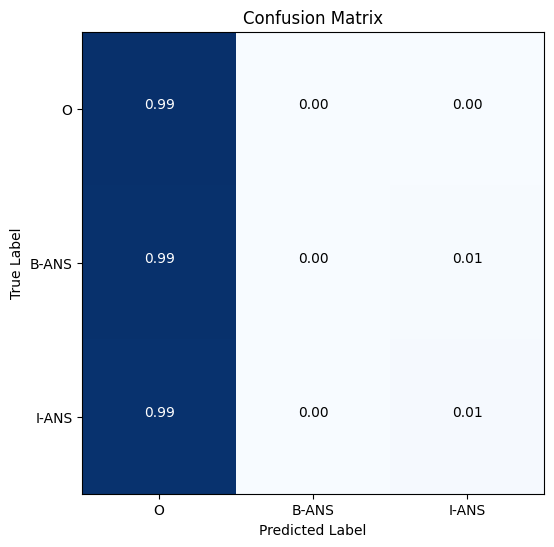

Classification Report:
              precision    recall  f1-score   support

           O       0.62      0.99      0.76     15789
       B-ANS       0.35      0.00      0.00      6674
       I-ANS       0.24      0.01      0.02      3137

    accuracy                           0.62     25600
   macro avg       0.40      0.34      0.26     25600
weighted avg       0.50      0.62      0.47     25600



In [8]:
model = BertForTokenClassification.from_pretrained(mbert_checkpoint, num_labels=3)
val_set = df_val.sample(50, shuffle=True) # Just to see poor performance quickly
display_results(*get_results(model, val_set, mbert_tokenizer))

In [9]:
# Weird memory issue fix
#model = None # before GC
#gc.collect()
#with torch.no_grad():
#    torch.cuda.empty_cache()

In [10]:
# Training cell
args = Seq2SeqTrainingArguments(
    # Memory efficient params
    fp16=False,
    auto_find_batch_size=True,

    output_dir=model_path,
    overwrite_output_dir = True,
    learning_rate=2e-5,

    num_train_epochs=5,
    weight_decay=0.01, # L2 regularization term
    generation_max_length=512,

    save_total_limit=5,
    save_strategy = "best",
    load_best_model_at_end = True,
    
    logging_strategy="epoch",
    eval_strategy = "epoch",
    log_level="info",
    report_to=[],
    logging_dir=None,
)

In [11]:
if not os.path.exists(model_path):
    print(f"No classifiers folder found, creating {model_path}...")
    os.makedirs(model_path)
if not TRAIN:
    if os.path.exists(save_path):
        print(f"Model already exists at {save_path}, loading model...")
        model = BertForTokenClassification.from_pretrained(save_path, num_labels=3)
        mbert_tokenizer = AutoTokenizer.from_pretrained(save_path)
    else:
        print("No model found.")
if TRAIN:
    print(f"No model found at {save_path}, training model...")
    model = BertForTokenClassification.from_pretrained(mbert_checkpoint, num_labels=3)
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=mbert_tokenizer, # type: ignore
        callbacks = [EarlyStoppingCallback(patience)]
    )
    trainer.train()
    print("Training completed.")
    model.save_pretrained(save_path) # type: ignore
    mbert_tokenizer.save_pretrained(save_path) # type: ignore
    print("Model saved.")

Model already exists at c:\Users\asge1\Downloads\nlp-project\results\answer_span_classifier_mbert\fine_tuned, loading model...


## First get a taste

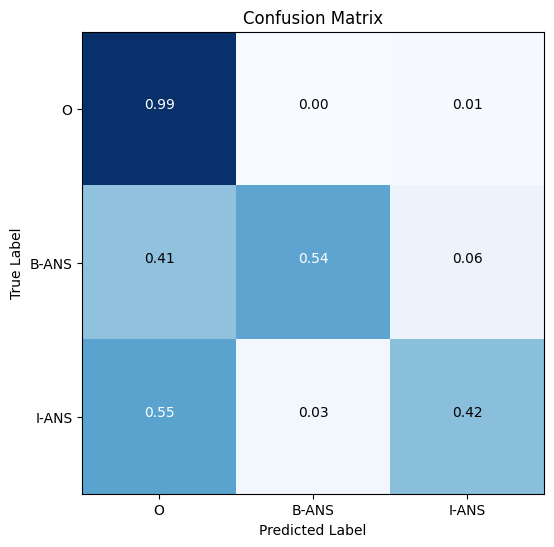

Classification Report:
              precision    recall  f1-score   support

           O       1.00      0.99      1.00     25436
       B-ANS       0.62      0.54      0.57        69
       I-ANS       0.22      0.42      0.29        95

    accuracy                           0.99     25600
   macro avg       0.61      0.65      0.62     25600
weighted avg       0.99      0.99      0.99     25600



In [12]:
smaller_val_set = df_val.sample(50, shuffle=True) # get 50 random samples
y_true, y_pred = get_results(model, smaller_val_set, mbert_tokenizer)
display_results(y_true, y_pred)

## Get Confusion Matrix for each language

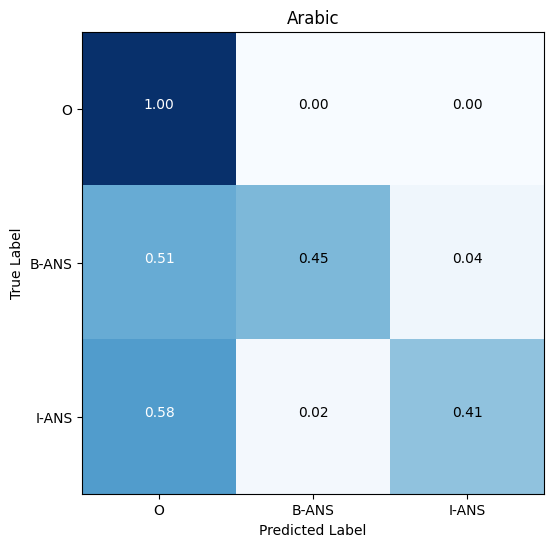

Classification Report:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00     25427
       B-ANS       0.51      0.45      0.48        55
       I-ANS       0.48      0.41      0.44       118

    accuracy                           0.99     25600
   macro avg       0.66      0.62      0.64     25600
weighted avg       0.99      0.99      0.99     25600



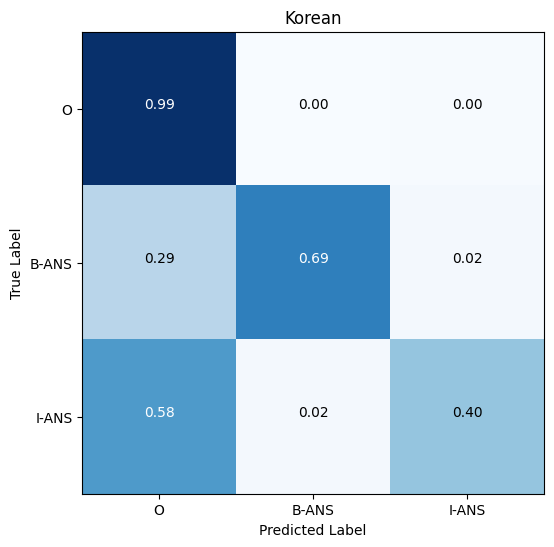

Classification Report:
              precision    recall  f1-score   support

           O       1.00      0.99      1.00     25401
       B-ANS       0.59      0.69      0.64        55
       I-ANS       0.31      0.40      0.35       144

    accuracy                           0.99     25600
   macro avg       0.63      0.69      0.66     25600
weighted avg       0.99      0.99      0.99     25600



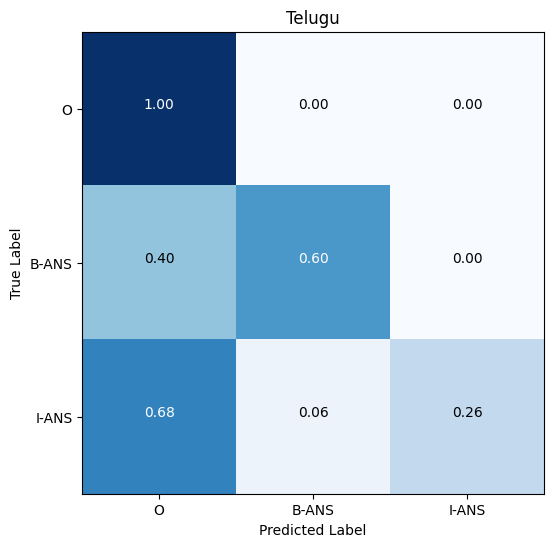

Classification Report:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00     25476
       B-ANS       0.50      0.60      0.55        55
       I-ANS       0.38      0.26      0.31        69

    accuracy                           0.99     25600
   macro avg       0.63      0.62      0.62     25600
weighted avg       0.99      0.99      0.99     25600



In [13]:
df_val_ar = df_val.filter(pl.col("lang") == "te")
df_val_ko = df_val.filter(pl.col("lang") == "ko")
df_val_te = df_val.filter(pl.col("lang") == "te")

df_val_ar = df_val_ar.with_columns(
    pl.struct(["question", "context", "answer_start", "answer"]).map_elements(
        lambda x: bio_sequence_labeler(x["answer_start"],x["answer"],x["question"],x["context"],
        mbert_tokenizer),
    return_dtype=pl.List(pl.Int8)).alias("labels")).sample(50, shuffle=True)
df_val_ko = df_val_ko.with_columns(
    pl.struct(["question", "context", "answer_start", "answer"]).map_elements(
        lambda x: bio_sequence_labeler(x["answer_start"],x["answer"],x["question"],x["context"],
        mbert_tokenizer),
    return_dtype=pl.List(pl.Int8)).alias("labels")).sample(50, shuffle=True)
df_val_te = df_val_te.with_columns(
    pl.struct(["question", "context", "answer_start", "answer"]).map_elements(
        lambda x: bio_sequence_labeler(x["answer_start"],x["answer"],x["question"],x["context"],
        mbert_tokenizer),
    return_dtype=pl.List(pl.Int8)).alias("labels")).sample(50, shuffle=True)

y_true, y_pred = get_results(model, df_val_ar, mbert_tokenizer)
display_results(y_true, y_pred, title="Arabic")
y_true, y_pred = get_results(model, df_val_ko, mbert_tokenizer)
display_results(y_true, y_pred, title="Korean")
y_true, y_pred = get_results(model, df_val_te, mbert_tokenizer)
display_results(y_true, y_pred, title="Telugu")

## Get full Confusion Matrix for fully trained model

In [14]:
#y_true, y_pred = get_results(model, df_val, mbert_tokenizer)
#display_results(y_true, y_pred)